In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import squarify
import matplotlib.pyplot as plt

In [2]:
# Loading dataset (an excel file with several tabs)
dataset = pd.read_excel('/Users/macpro/Downloads/Final_project_RFM/Dataset.xlsx', sheet_name=None)

# Understanding dataset
for sheet_name,sheet_content in dataset.items():
  print('Sheet Name: {}'.format(sheet_name))
  print(sheet_content.info())
  globals()[sheet_name] = dataset[sheet_name] # Converting each tab in the excel file from an item in dictionary to a global variable

Sheet Name: Orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Channel        9994 non-null   object        
 7   Postal Code    9994 non-null   int64         
 8   Product ID     9994 non-null   object        
 9   Sales          9994 non-null   float64       
 10  Quantity       9994 non-null   int64         
 11  Unit Price     9994 non-null   float64       
 12  Discount       9994 non-null   float64       
 13  Profit         9994 non-null   float64       
 14  Unnamed: 14    0 non-null      float64       
 15  Cu

In [3]:
# Convert 5-digit format of date (if necessary)

# import xlrd
# Orders['Order Date'] = Orders['Order Date'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
# Orders['Ship Date'] = Orders['Ship Date'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))

In [4]:
# Left joining 'Orders' Dataframe with 'Return' Dataframe
return_merge = pd.merge(Orders, Return, on='Order ID', how='left')

# Selecting only Order_IDs that are not returned
return_merge = return_merge[return_merge['Returned']!='Yes']

# Inner joining the 'Customer' Dataframe with the 'return_merge' Dataframe
customer_merge = pd.merge(Customer, return_merge, on='Customer ID', how='inner')

# Adding 'Day Difference' column to calculate the difference between order date and 31/12/2017 (to calculate Recency)
customer_merge['Day Difference']=(pd.to_datetime('2017-12-31') - customer_merge['Order Date']).dt.days

In [5]:
# Creating 'RFM' Dataframe to calculate RFM 
RFM = customer_merge.groupby('Customer ID').agg(
    Recency=('Day Difference','min'), # find the min day difference (the most recent order date)
    Frequency=('Order ID','nunique'), # count total orders
    Monetary_Value=('Sales','sum'), # calculate total sales
    ).reset_index()

In [6]:
# Creating 'RFM_Score' Dataframe, using pd.qcut to create quintiles
RFM['R'] = pd.qcut(RFM['Recency'], q=5, labels=[5,4,3,2,1])
RFM['F'] = pd.qcut(RFM['Frequency'], q=5, labels=[1,2,3,4,5])
RFM['M'] = pd.qcut(RFM['Monetary_Value'], q=5, labels=[1,2,3,4,5])
RFM['RFM Score'] = RFM['R'].astype(str) + RFM['F'].astype(str) + RFM['M'].astype(str)
RFM['RFM Score'] = RFM['RFM Score'].astype(int)
RFM.head(10)

,Customer ID,Recency,Frequency,Monetary_Value,R,F,M,RFM Score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112
5,AB-10060,55,8,7755.620,4,4,5,445
6,AB-10105,42,9,13881.263,4,5,5,455
7,AB-10150,42,5,966.710,4,2,2,422
8,AB-10165,26,8,1113.838,5,4,2,542
9,AB-10255,167,8,897.482,2,4,2,242


In [7]:
seg = dataset['Sheet2']
seg['RFM Score'] = seg['RFM Score'].str.split(',')
seg = seg.explode('RFM Score').reset_index(drop=True)
seg['RFM Score'] = seg['RFM Score'].astype(int)
seg.sort_values(by='RFM Score')
seg.head(10)

,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
5,Champions,455
6,Champions,445
7,Loyal,543
8,Loyal,444
9,Loyal,435


In [8]:
joined = pd.merge(RFM, seg, on='RFM Score', how='left')
joined

,Customer ID,Recency,Frequency,Monetary_Value,R,F,M,RFM Score,Segment
0,AA-10315,185,5,5563.560,2,2,5,225,At Risk
1,AA-10375,20,9,1056.390,5,5,2,552,Potential Loyalist
2,AA-10480,260,4,1790.512,2,1,3,213,About To Sleep
3,AA-10645,483,5,5073.975,1,2,5,125,At Risk
4,AB-10015,416,3,886.156,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353,Potential Loyalist
787,YC-21895,5,4,5438.650,5,1,5,515,Promising
788,YS-21880,10,8,6720.444,5,4,5,545,Champions
789,ZC-21910,55,12,7892.998,4,5,5,455,Champions


/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_7851/2815570392.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


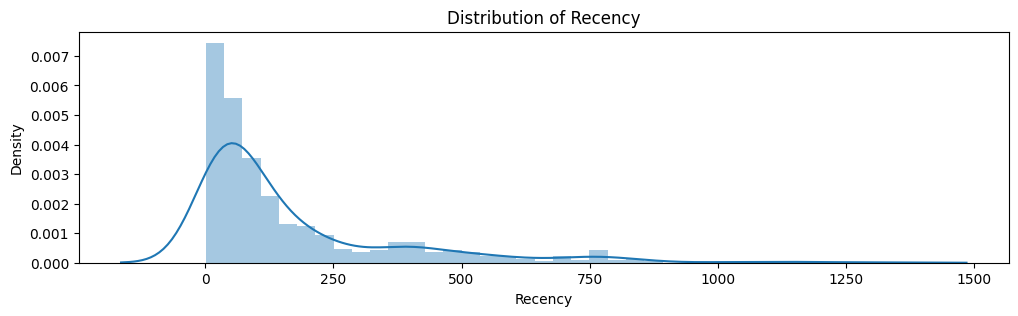

/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_7851/2815570392.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


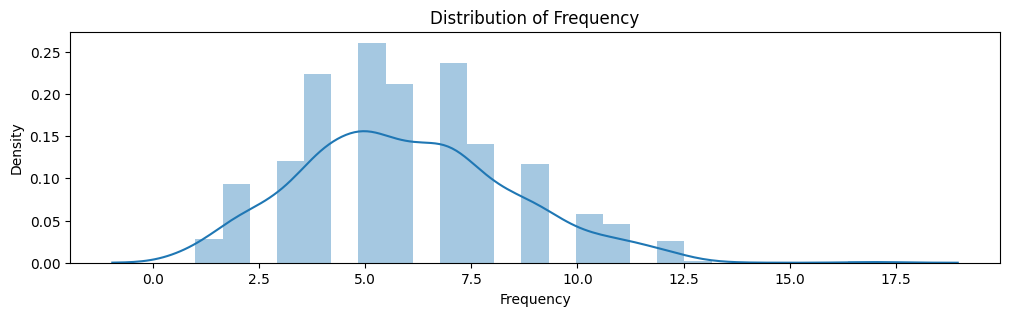

/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_7851/2815570392.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


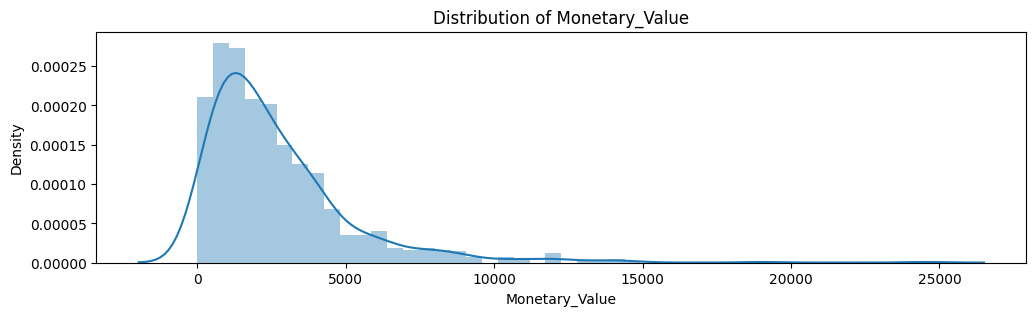

In [9]:
# show distribution of each variable of the model

colnames = ['Recency', 'Frequency', 'Monetary_Value']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(joined[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

- From the plots, it can be seen that the distribution of Recency is right-skewed, showing that a considerable number of customers have made a recent purchase (within 200 days). This suggests a higher engagement level and that a part of customer base is active and potentially more likely to make repeat purchases. However, the distribution is quite dispersed with long tails, which means that there are also groups of customers who made last purchase long time ago.
- The distribution of Frequency is slightly right-skewed with higher dispersion, with the majority of customers making from 3 - 8 orders. 
- The distribution of Monetary value is right-skewed with lower dispersion, which indicates that the majority of customers have spent relatively lower amounts (below 4000), while a smaller segment represents higher spenders. The long tail indicates that there are a few customers with much higher monetary value (above 10000)

In [10]:
# Creating 'RFM_segment' Dataframe which presents the count of each segment
RFM_segment = joined['Segment'].value_counts().sort_values(ascending=True).reset_index(name='count')
print(RFM_segment)

                    index  count
0        Cannot Lose Them     36
1          About To Sleep     44
2           New Customers     61
3                   Loyal     62
4               Promising     63
5               Champions     71
6          Need Attention     72
7          Lost customers     83
8   Hibernating customers     90
9                 At Risk     96
10     Potential Loyalist    113


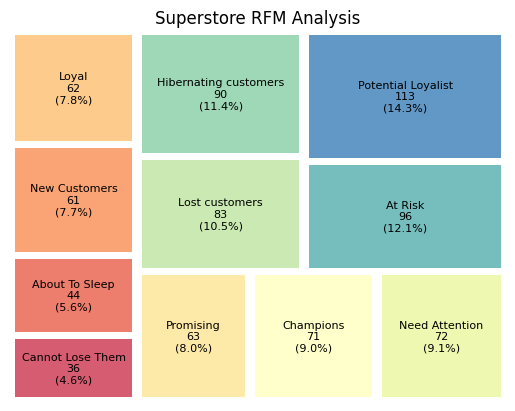

In [11]:
# Creating Treemap using squarify
perc = [str('\n{}\n({:.1%})'.format(i, i/RFM_segment['count'].sum())) for i in RFM_segment['count']]
label=list(RFM_segment['index'] + perc)
heatmap = squarify.plot(sizes=RFM_segment['count'], label=label, 
              color=sns.color_palette("Spectral", len(RFM_segment['count'])), 
              alpha=.8, 
              pad=2,
              text_kwargs={'fontsize': 8})
heatmap.set_title('Superstore RFM Analysis')
plt.axis('off')
plt.show()

### Analysis
- Potential loyalist account for the largest proportion in the list of customer segments (14.3%). These customers have made several orders with Superstore and might have come back recently, yet their total spending is quite low or just average. For this segment, Superstore is recommended to involve them in loyalty programs (membership program,...). There should be product recommendation and discount offers for them.
- Unfortunately, at risk, hibernating and lost customers segments rank second, third and fourth (12.1%, 11.4% and 10.5% respectively). 34% of Superstore customers have not made any recent purchases, which is alarming. For At risk and Hibernating customers, Superstore can send personalized messages, special offers, relevant product recommendations to reconnect with them. Lost customers can be ignored if both mass and personalized campaigns don't work for them
- For the most important segment, Champion (9.0%), Loyal (7.8%) and Cannot Lose Them (4.6%), Superstore needs to create a personalized, meaningful connection between customers and brand. Don't let competitors take these customers. Make them the brand ambassadors. Increase the proportion of these segments as currently, they account for a relatively small percentage.